In [1]:
!pip install numpy pandas matplotlib seaborn

In [2]:
#dataset info: https://github.com/allisonhorst/palmerpenguins/blob/main/README.md

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report

import os
import warnings
from itertools import combinations


warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
def get_dataframes():
    dataframes = []
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            path = os.path.join(dirname, filename)
            print(path)
            dataframes.append(pd.read_csv(path))
    return dataframes


df_size, df_lter = get_dataframes()
# print(df_size.columns)
# print(df_lter.columns)
df_size

/kaggle/input/palmer-archipelago-antarctica-penguin-data/penguins_size.csv
/kaggle/input/palmer-archipelago-antarctica-penguin-data/penguins_lter.csv


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE


**[2] Вывести в табличной форме статистику по датасету, включая**

In [4]:
isnull_objects_percent =  round(df_size.isnull().any(axis=1).sum() / df_size.shape[0] * 100, 2)

dataset_stats_df = pd.DataFrame([
    ['size', df_size.shape],
    ['feautures', df_size.shape[1] - 1],
    ['classes num', df_size['species'].nunique()],
    ['isnull objects %', isnull_objects_percent]
], columns=['characteristics', 'value'])

class_counts = df_size['species'].value_counts().reset_index()
class_counts.columns = ['characteristics', 'value']

numeric_features = df_size.select_dtypes(include=['number']).columns
categorical_features = df_size.select_dtypes(include=['object']).columns

additional_info = pd.DataFrame([
    ['numeric features', len(numeric_features)],
    ['categorical features', len(categorical_features)]
], columns=['characteristics', 'value'])

dataset_stats_df = pd.concat([dataset_stats_df, class_counts, additional_info], ignore_index=True)

dataset_stats_df

,characteristics,value
0,size,"(344, 7)"
1,feautures,6
2,classes num,3
3,isnull objects %,2.91
4,Adelie,152
5,Gentoo,124
6,Chinstrap,68
7,numeric features,4
8,categorical features,3


In [5]:
df_size.replace([float('inf'), float('-inf')], float('nan'), inplace=True)
df_size = df_size.dropna()
df_size.drop(columns=['sex', 'island'], inplace=True)
df_size

/tmp/ipykernel_17/224246325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_size.drop(columns=['sex', 'island'], inplace=True)


,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
4,Adelie,36.7,19.3,193.0,3450.0
5,Adelie,39.3,20.6,190.0,3650.0
...,...,...,...,...,...
338,Gentoo,47.2,13.7,214.0,4925.0
340,Gentoo,46.8,14.3,215.0,4850.0
341,Gentoo,50.4,15.7,222.0,5750.0
342,Gentoo,45.2,14.8,212.0,5200.0


**[3] Выполнить визуализацию датасета по всем парам выбранных количественных
переменных, обозначая:**
- в графиках с разными парами переменных объекты из разных классов
различными по форме и цвету точками,
- в графиках с одной и той же парой переменных – гистограммы с достаточным
числом разбиений (обычно – не менее 20), либо плотности распределения
переменной по оси признака.

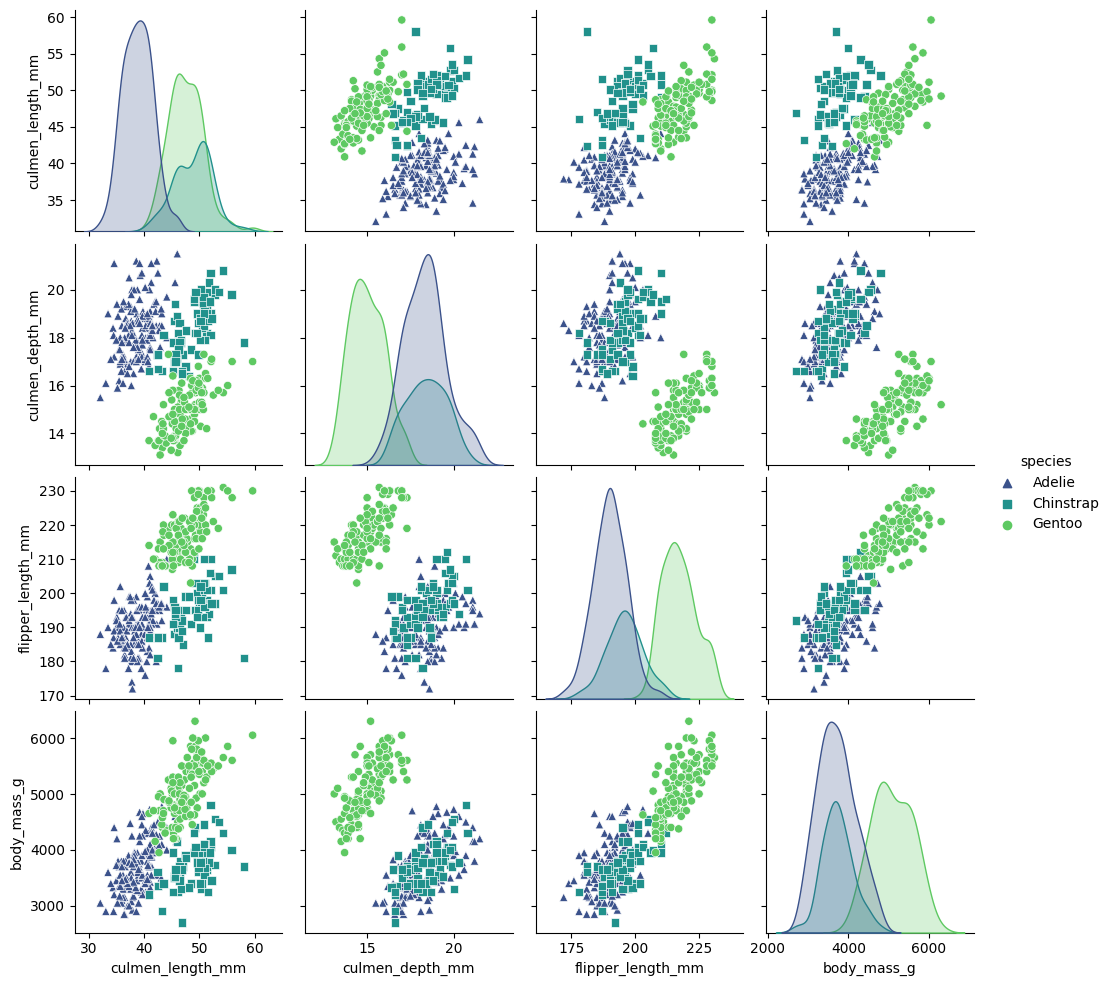

In [6]:
pair_plot = sns.pairplot(df_size, hue='species', palette='viridis', markers=['^', 's', 'o'])
plt.show()

**[4] В табличном варианте оценить степень сопряженности пар признаковпеременных на всем датасете, используя коэффициент корреляции Пирсона.
В табличном варианте оценить степень сопряженности пар признаков-переменных
в каждом классе датасета, используя коэффициент корреляции Пирсона.**

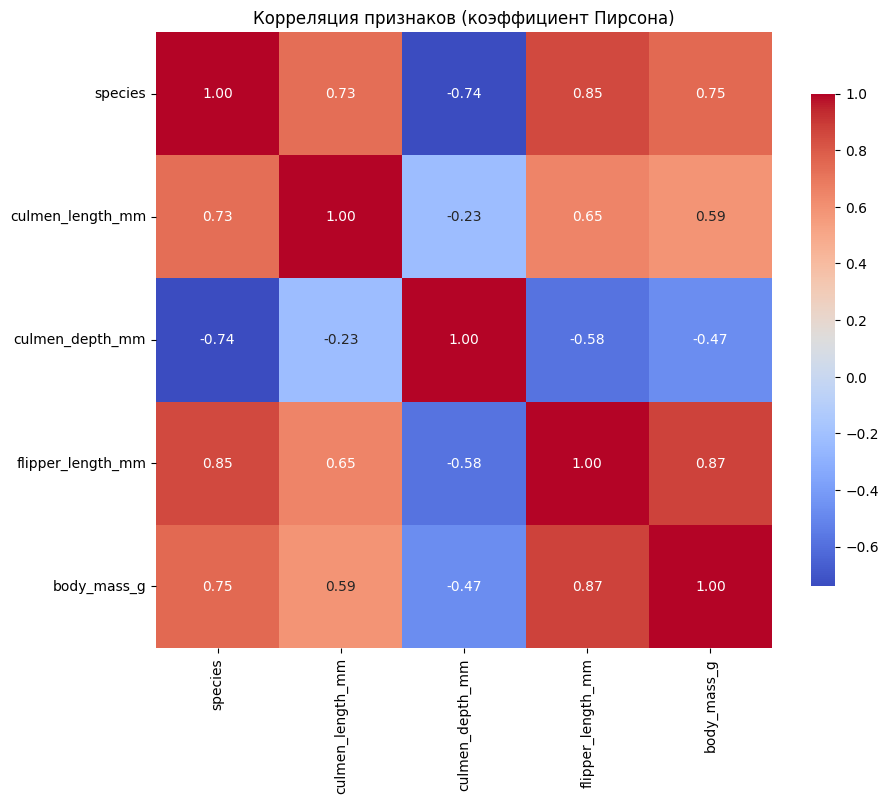

In [7]:
discrete_encoded_df = df_size.copy(deep=True)
discrete_encoded_df['species'] = df_size['species'].replace({'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2})

correlation_matrix = discrete_encoded_df.corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Корреляция признаков (коэффициент Пирсона)')
plt.show()

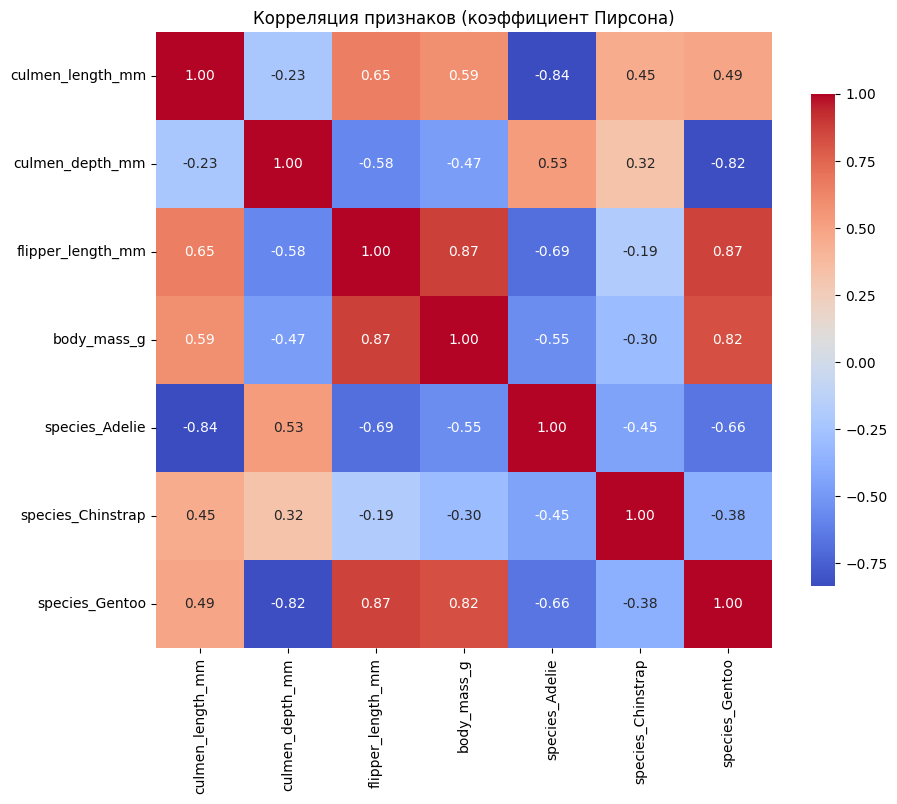

In [8]:
one_hot_df_size = pd.get_dummies(df_size, columns=['species'], drop_first=False)

correlation_matrix = one_hot_df_size.corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Корреляция признаков (коэффициент Пирсона)')
plt.show()

In [9]:
df_size_two_classes = df_size.copy(deep=True)
df_size_two_classes.drop(df_size_two_classes[df_size_two_classes['species'] == 'Chinstrap'].index, inplace=True)
df_size_two_classes.rename(columns={'species': 'Adelie'}, inplace=True)
df_size_two_classes['Adelie'] = df_size['species'].replace({'Adelie': 1, 'Gentoo': 0})
df_size_two_classes['Adelie'] = df_size_two_classes['Adelie'].astype(bool)
df_size_two_classes

,Adelie,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,True,39.1,18.7,181.0,3750.0
1,True,39.5,17.4,186.0,3800.0
2,True,40.3,18.0,195.0,3250.0
4,True,36.7,19.3,193.0,3450.0
5,True,39.3,20.6,190.0,3650.0
...,...,...,...,...,...
338,False,47.2,13.7,214.0,4925.0
340,False,46.8,14.3,215.0,4850.0
341,False,50.4,15.7,222.0,5750.0
342,False,45.2,14.8,212.0,5200.0


**[5] Выбрать пару целевых классов и все количественные признаки.
Используя метод LDA (линейный дискриминантный анализ), построить решающую
функцию алгоритма, разграниченные решающей функцией зоны и отдельные
объекты классов на всех парах количественных признаков.**

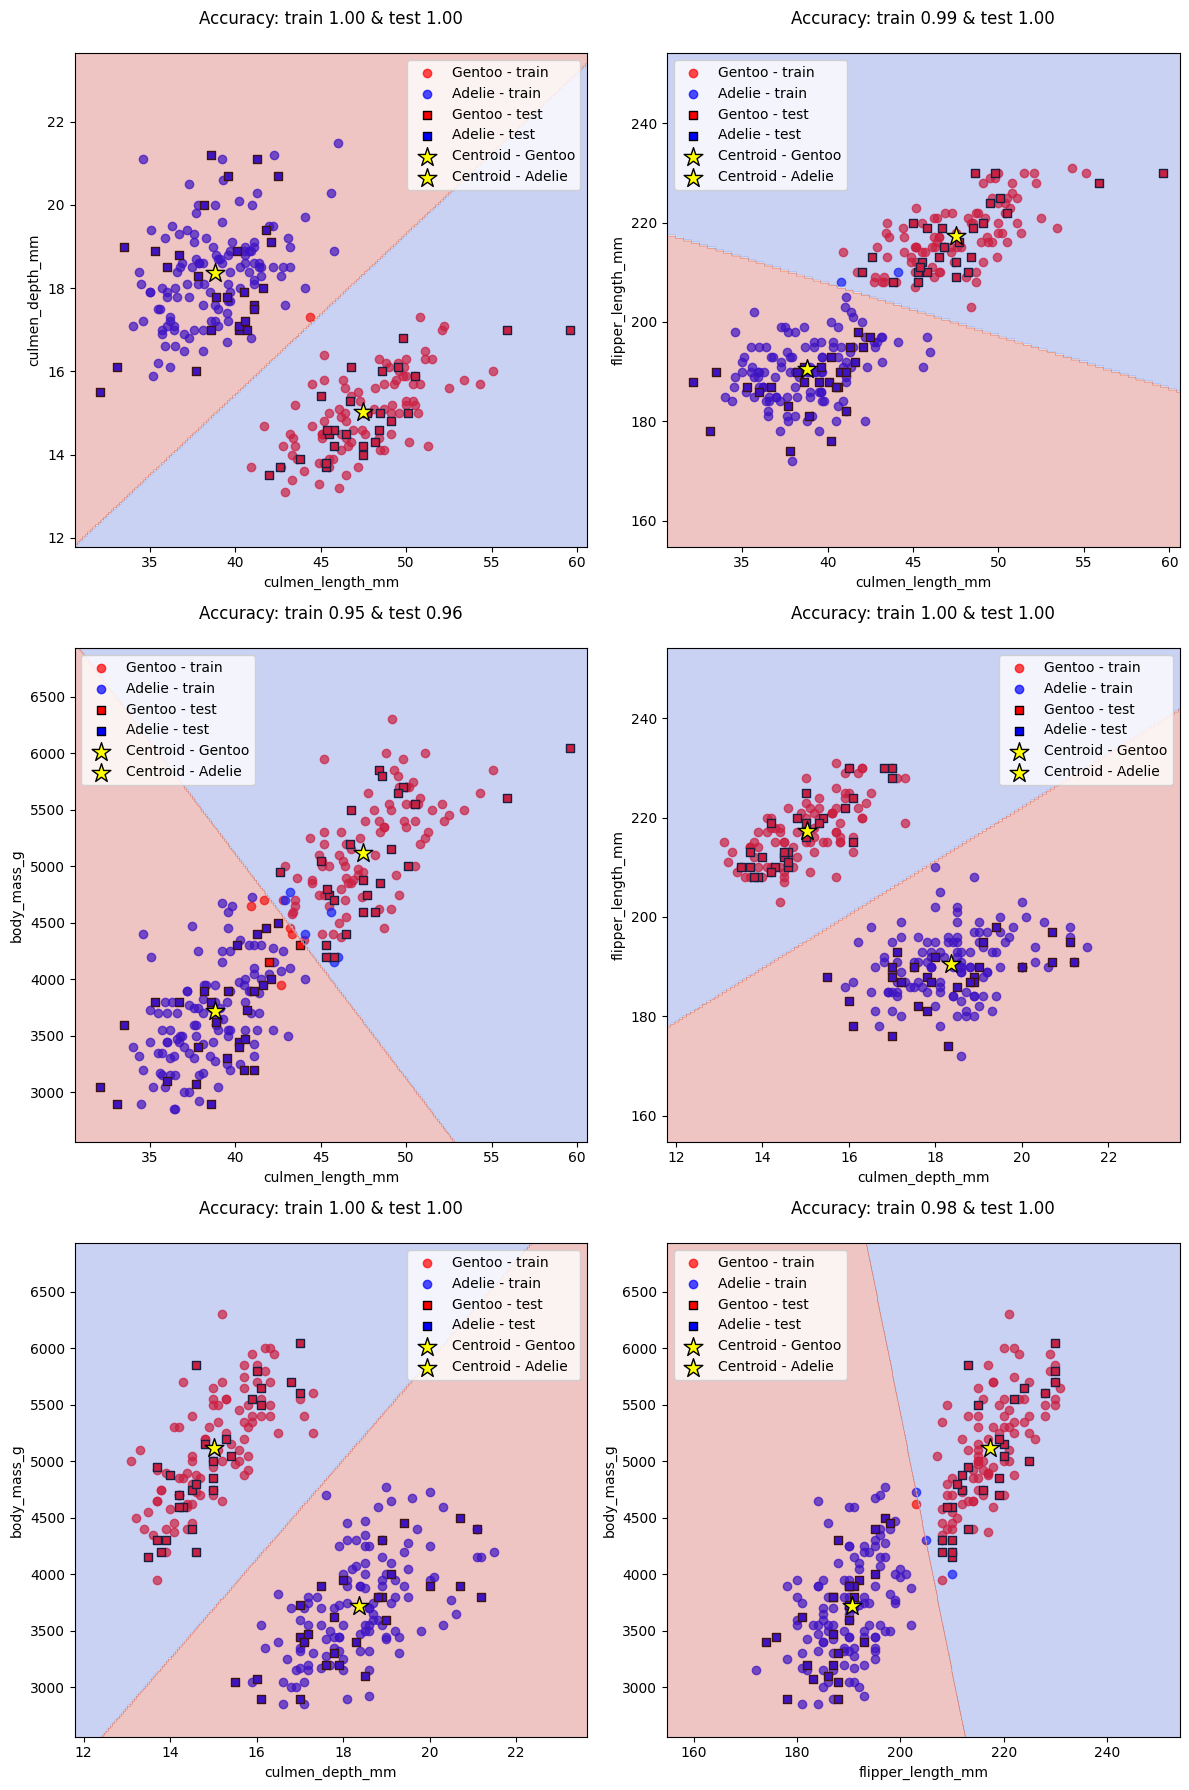

Average train accuracy: 0.9858
Average test accuracy: 0.9938


In [10]:
X = df_size_two_classes[['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']]
y = df_size_two_classes['Adelie'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
feature_pairs = list(combinations([0, 1, 2, 3], 2))
feature_pair_names = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']


def plot_lda_for_feature_pair(lda, X_train, X_test, y_train, y_test, feature_pair, ax):
    # Выбираем пару признаков, используя .iloc
    X_train_pair = X_train.iloc[:, list(feature_pair)].values
    X_test_pair = X_test.iloc[:, list(feature_pair)].values

    lda.fit(X_train_pair, y_train)
    y_train_pred = lda.predict(X_train_pair)
    y_test_pred = lda.predict(X_test_pair)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    ax.scatter(X_train_pair[y_train == 0][:, 0], X_train_pair[y_train == 0][:, 1], color='red', marker='o', label='Gentoo - train', alpha=0.7)
    ax.scatter(X_train_pair[y_train == 1][:, 0], X_train_pair[y_train == 1][:, 1], color='blue', marker='o', label='Adelie - train', alpha=0.7)
    ax.scatter(X_test_pair[y_test == 0][:, 0], X_test_pair[y_test == 0][:, 1], color='red', marker='s', label='Gentoo - test', edgecolor='k')
    ax.scatter(X_test_pair[y_test == 1][:, 0], X_test_pair[y_test == 1][:, 1], color='blue', marker='s', label='Adelie - test', edgecolor='k')

    # Decision boundary
    x_min, x_max = X_train_pair[:, 0].min() - 0.1 * X_train_pair[:, 0].min(), X_train_pair[:, 0].max() + 0.1 * X_train_pair[:, 0].max()
    y_min, y_max = X_train_pair[:, 1].min() - 0.1 * X_train_pair[:, 1].min(), X_train_pair[:, 1].max() + 0.1 * X_train_pair[:, 1].max()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000), np.linspace(y_min, y_max, 200))

    Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

    centroid_class_0 = X_train_pair[y_train == 0].mean(axis=0)
    centroid_class_1 = X_train_pair[y_train == 1].mean(axis=0)
    ax.scatter(centroid_class_0[0], centroid_class_0[1], color='yellow', marker='*', s=200, label='Centroid - Gentoo', edgecolor='black')
    ax.scatter(centroid_class_1[0], centroid_class_1[1], color='yellow', marker='*', s=200, label='Centroid - Adelie', edgecolor='black')

    ax.set_xlabel(feature_pair_names[feature_pair[0]])
    ax.set_ylabel(feature_pair_names[feature_pair[1]])
    ax.set_title(f"Accuracy: train {train_accuracy:.2f} & test {test_accuracy:.2f}\n")
    ax.legend()
    return train_accuracy, test_accuracy



fig, axes = plt.subplots(3, 2, figsize=(12, 18))
axes = axes.ravel()

lda = LDA()

train_accuracies = []
test_accuracies = []


for i, feature_pair in enumerate(feature_pairs):
    train_acc, test_acc = plot_lda_for_feature_pair(lda, X_train, X_test, y_train, y_test, feature_pair, axes[i])
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

plt.tight_layout()
plt.show()

print(f"Average train accuracy: {np.mean(train_accuracies):.4f}")
print(f"Average test accuracy: {np.mean(test_accuracies):.4f}")

**[6] Для одной из пар количественных признаков из пункта [5] на одном рисунке
одновременно построить (а) решающую функцию LDA и (б) линейную регрессию
одного количественного признака от другого.**

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


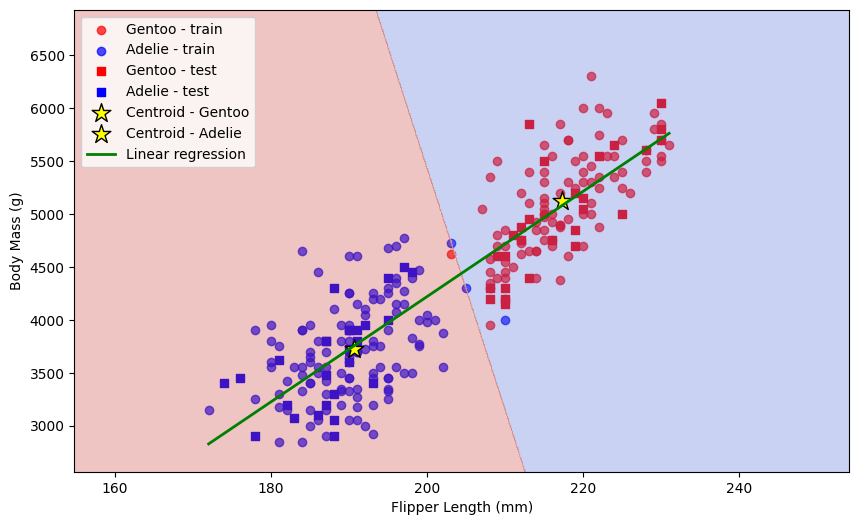

In [11]:
two_featurues_two_classes_df = df_size_two_classes.copy(deep=True)
X = two_featurues_two_classes_df[['flipper_length_mm', 'body_mass_g']]
y = two_featurues_two_classes_df['Adelie'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

lda = LDA()
lda.fit(X_train, y_train)

y_lda_train_pred = lda.predict(X_train)
y_lda_test_pred = lda.predict(X_test)

train_lda_accuracy = accuracy_score(y_train, y_lda_train_pred)
test_lda_accuracy = accuracy_score(y_test, y_lda_test_pred)

lr = LinearRegression()
lr.fit(X_train[['flipper_length_mm']], X_train['body_mass_g'])

plt.figure(figsize=(10, 6))

# Индексация для визуализации
plt.scatter(X_train[y_train == 0].iloc[:, 0], X_train[y_train == 0].iloc[:, 1], color='red', marker='o', label='Gentoo - train', alpha=0.7)
plt.scatter(X_train[y_train == 1].iloc[:, 0], X_train[y_train == 1].iloc[:, 1], color='blue', marker='o', label='Adelie - train', alpha=0.7)
plt.scatter(X_test[y_test == 0].iloc[:, 0], X_test[y_test == 0].iloc[:, 1], color='red', marker='s', label='Gentoo - test')
plt.scatter(X_test[y_test == 1].iloc[:, 0], X_test[y_test == 1].iloc[:, 1], color='blue', marker='s', label='Adelie - test')

# Определение границы решения
x_min, x_max = X_train['flipper_length_mm'].min() - 0.1 * X_train['flipper_length_mm'].min(), X_train['flipper_length_mm'].max() + 0.1 * X_train['flipper_length_mm'].max()
y_min, y_max = X_train['body_mass_g'].min() - 0.1 * X_train['body_mass_g'].min(), X_train['body_mass_g'].max() + 0.1 * X_train['body_mass_g'].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000), np.linspace(y_min, y_max, 1000))

Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

# Центроиды
centroid_class_0 = X_train[y_train == 0].mean(axis=0)
centroid_class_1 = X_train[y_train == 1].mean(axis=0)
plt.scatter(centroid_class_0[0], centroid_class_0[1], color='yellow', marker='*', s=200, label='Centroid - Gentoo', edgecolor='black')
plt.scatter(centroid_class_1[0], centroid_class_1[1], color='yellow', marker='*', s=200, label='Centroid - Adelie', edgecolor='black')

line_x = np.linspace(X_train['flipper_length_mm'].min(), X_train['flipper_length_mm'].max(), 100)
line_y = lr.predict(line_x.reshape(-1, 1))

plt.plot(line_x, line_y, color='green', label='Linear regression', linewidth=2)
plt.xlabel('Flipper Length (mm)')
plt.ylabel('Body Mass (g)')
plt.legend()
plt.show()


**[7] Выбрать два количественных признака и пару целевых классов
На отдельных рисунках с осями количественных признаков построить решающие
функции, разграниченные решающей функцией зоны и отдельные объекты
классов для методов (а) LDA, (б) SVM, (в) логистическая регрессия, (г) наивный
байесовский классификатор**

LDA train accuracy: 0.98
LDA test accuracy: 0.99
SVM train accuracy: 0.98
SVM test Accuracy: 0.99
Logistic Regression train accuracy: 0.98
Logistic Regression test Accuracy: 0.99
Naive Bayes train accuracy: 0.98
Naive Bayes test Accuracy: 0.99


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


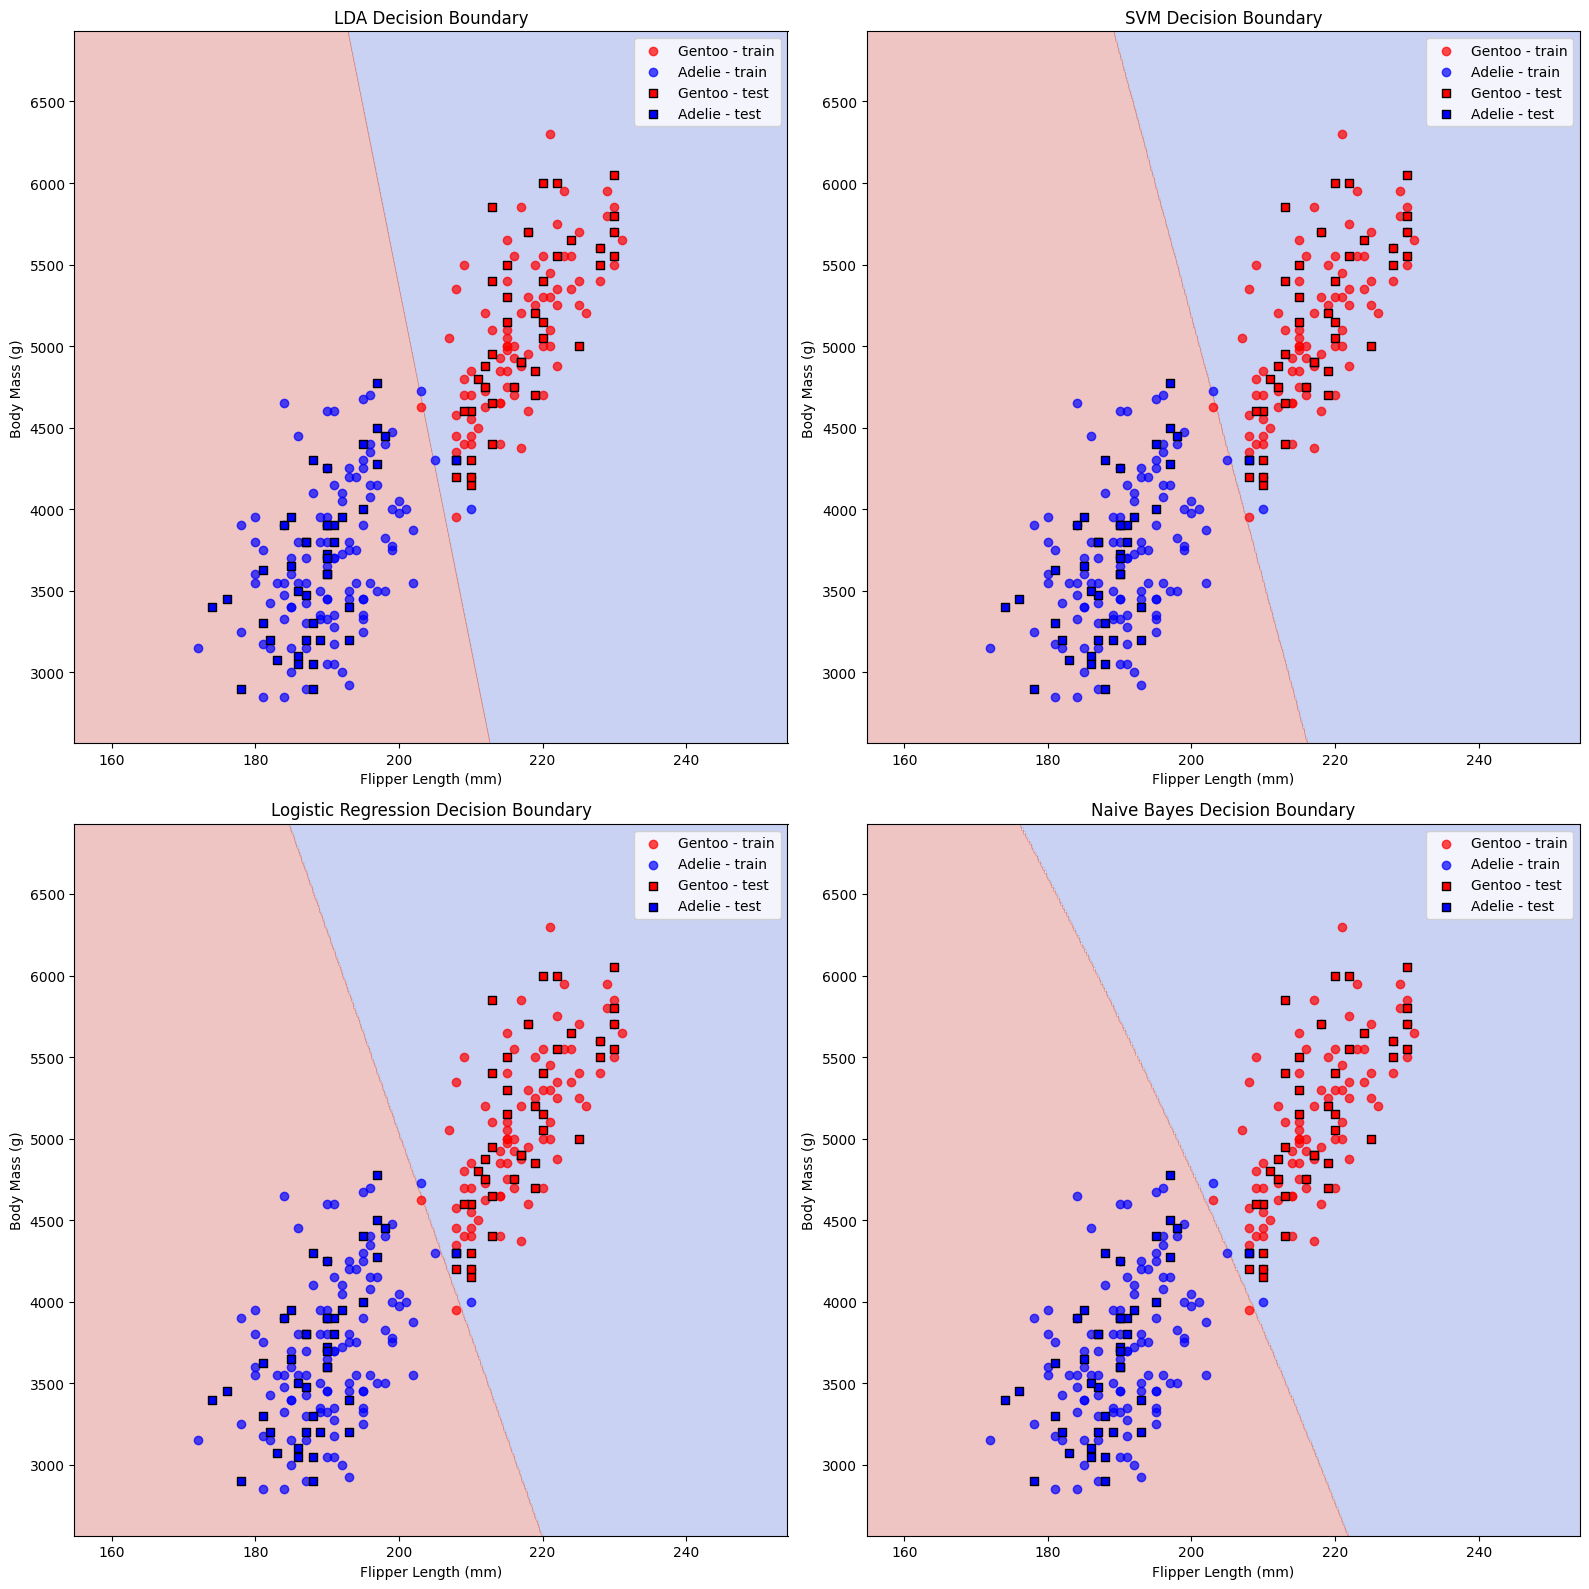

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


def plot_decision_boundaries(model, title, ax):
    x_min, x_max = X_train['flipper_length_mm'].min() - 0.1 * X_train['flipper_length_mm'].min(), X_train['flipper_length_mm'].max() + 0.1 * X_train['flipper_length_mm'].max()
    y_min, y_max = X_train['body_mass_g'].min() - 0.1 * X_train['body_mass_g'].min(), X_train['body_mass_g'].max() + 0.1 * X_train['body_mass_g'].max()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000), np.linspace(y_min, y_max, 200))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    
    ax.scatter(X_train[y_train == 0].iloc[:, 0], X_train[y_train == 0].iloc[:, 1], color='red', marker='o', label='Gentoo - train', alpha=0.7)
    ax.scatter(X_train[y_train == 1].iloc[:, 0], X_train[y_train == 1].iloc[:, 1], color='blue', marker='o', label='Adelie - train', alpha=0.7)
    ax.scatter(X_test[y_test == 0].iloc[:, 0], X_test[y_test == 0].iloc[:, 1], color='red', marker='s', label='Gentoo - test', edgecolor='k')
    ax.scatter(X_test[y_test == 1].iloc[:, 0], X_test[y_test == 1].iloc[:, 1], color='blue', marker='s', label='Adelie - test', edgecolor='k')
    
    ax.set_xlabel('Flipper Length (mm)')
    ax.set_ylabel('Body Mass (g)')
    ax.set_title(title)
    ax.legend()

# LDA
lda = LDA()
lda.fit(X_train, y_train)
y_pred_train_lda = lda.predict(X_train)
y_pred_test_lda = lda.predict(X_test)
print(f'LDA train accuracy: {accuracy_score(y_train, y_pred_train_lda):.2f}')
print(f'LDA test accuracy: {accuracy_score(y_test, y_pred_test_lda):.2f}')

# SVM
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)
y_pred_train_svm = svm.predict(X_train)
y_pred_test_svm = svm.predict(X_test)
print(f'SVM train accuracy: {accuracy_score(y_train, y_pred_train_svm):.2f}')
print(f'SVM test Accuracy: {accuracy_score(y_test, y_pred_test_svm):.2f}')

# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_train_lr = log_reg.predict(X_train)
y_pred_test_lr = log_reg.predict(X_test)
print(f'Logistic Regression train accuracy: {accuracy_score(y_train, y_pred_train_lr):.2f}')
print(f'Logistic Regression test Accuracy: {accuracy_score(y_test, y_pred_test_lr):.2f}')

# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_train_nb = nb.predict(X_train)
y_pred_test_nb = nb.predict(X_test)
print(f'Naive Bayes train accuracy: {accuracy_score(y_train, y_pred_train_nb):.2f}')
print(f'Naive Bayes test Accuracy: {accuracy_score(y_test, y_pred_test_nb):.2f}')

fig, axs = plt.subplots(2, 2, figsize=(16, 16))

plot_decision_boundaries(lda, 'LDA Decision Boundary', axs[0, 0])
plot_decision_boundaries(svm, 'SVM Decision Boundary', axs[0, 1])
plot_decision_boundaries(log_reg, 'Logistic Regression Decision Boundary', axs[1, 0])
plot_decision_boundaries(nb, 'Naive Bayes Decision Boundary', axs[1, 1])

plt.tight_layout()
plt.show()

**[8] Выбрать целевой класс и для каждого метода из пункта [7]:**
- Вывести матрицу ошибок.
- Вывести значения sensitivity, specificity, precision, recall.
- Построить ROC кривую и рассчитать метрику AUC.

Confusion Matrix:
[[39  0]
 [ 1 40]]
Sensitivity: 0.98
Specificity: 1.00
Precision: 1.00
Recall: 0.98


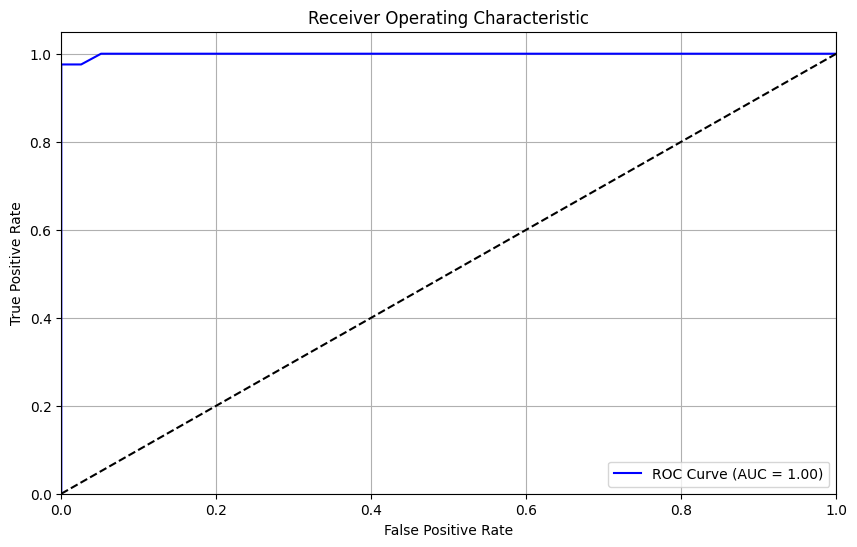

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        39
           1       1.00      0.98      0.99        41

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80

Confusion Matrix:
[[39  0]
 [ 1 40]]
Sensitivity: 0.98
Specificity: 1.00
Precision: 1.00
Recall: 0.98


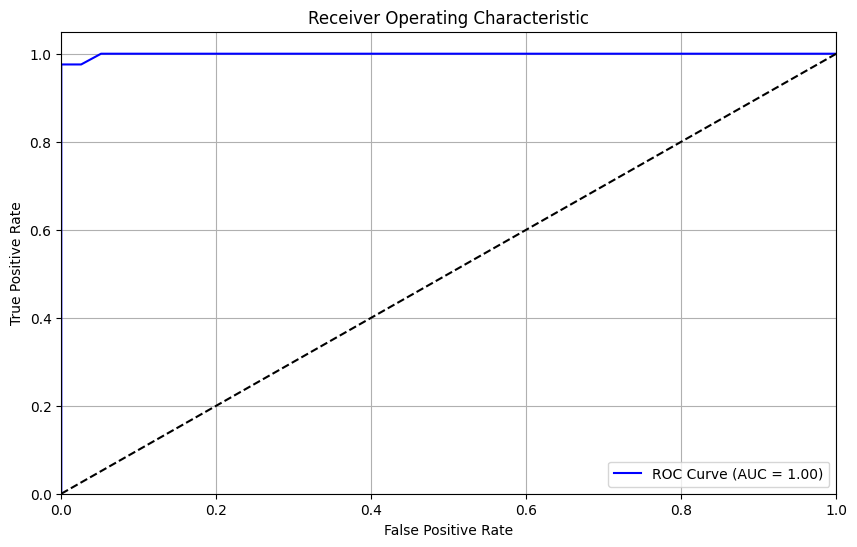

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        39
           1       1.00      0.98      0.99        41

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80

Confusion Matrix:
[[39  0]
 [ 1 40]]
Sensitivity: 0.98
Specificity: 1.00
Precision: 1.00
Recall: 0.98


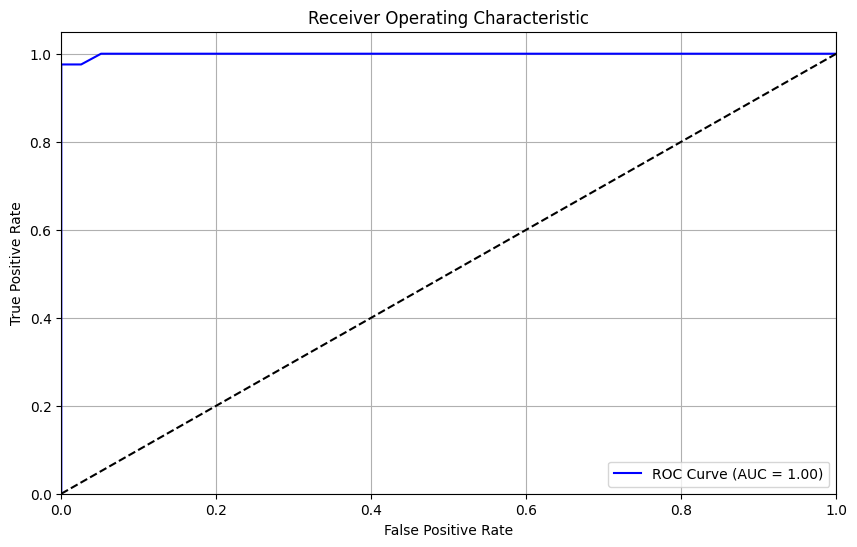

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        39
           1       1.00      0.98      0.99        41

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80

Confusion Matrix:
[[39  0]
 [ 1 40]]
Sensitivity: 0.98
Specificity: 1.00
Precision: 1.00
Recall: 0.98


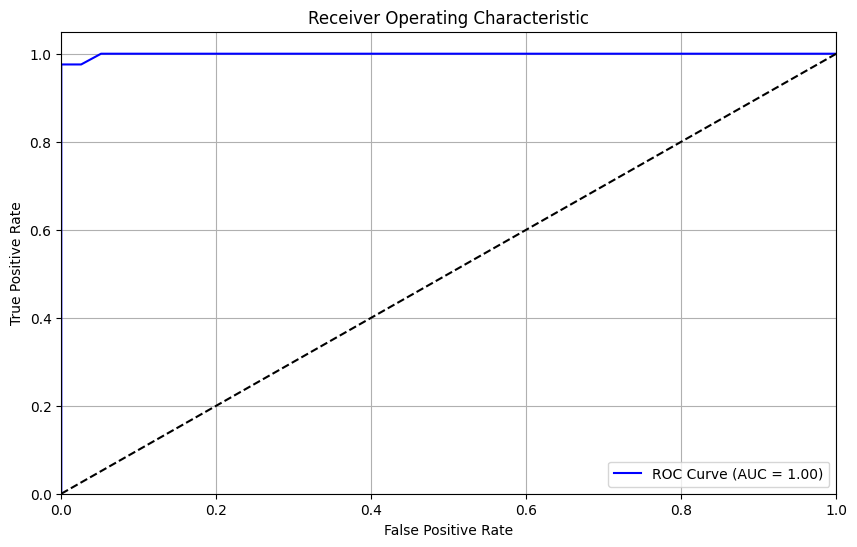

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        39
           1       1.00      0.98      0.99        41

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



In [13]:
target_class = 1


def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_pred_test = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred_test)
    print("Confusion Matrix:")
    print(cm)

    
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)  # True Positive Rate
    specificity = tn / (tn + fp)  # True Negative Rate
    precision = tp / (tp + fp)     # Precision
    recall = tp / (tp + fn)        # Recall

    print(f'Sensitivity: {sensitivity:.2f}')
    print(f'Specificity: {specificity:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')

    # ROC-кривая
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Отчет о классификации
    print(classification_report(y_test, y_pred_test))


evaluate_model(lda, X_train, y_train, X_test, y_test)
evaluate_model(svm, X_train, y_train, X_test, y_test)
evaluate_model(log_reg, X_train, y_train, X_test, y_test)
evaluate_model(nb, X_train, y_train, X_test, y_test)